In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import pandas as pd
import matplotlib 
from astropy.table import Table

In [2]:
# define a funtion to return 0 when divided by zero
def div0( a, b, fill=0. ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

def normalize(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data))) + 1


def df2array(df):
    lists = []
    for i in range(len(df)):
        lists.append(df.iloc[i][0])
    return np.array(lists)


# define a function that resamples the data based on wavelength
# has 3 1darray inputs: target_array is the array that has the sampling you want;
# ref_array is the array that has the same kind of data with the target_array but with different sampling rate:
# and the input_array is the array sharing the same sampling rate but not necessicirally the same data with the ref_array

# this function resamlpes the ref_array to the same sampling as the target_array first and then
# use the indecies to resample the input array, output is the resampled input_array


def resampling(target_array, ref_array, input_array, resamp_ref_array=False):

    # for each value in the target_array, find the indeices of the value(s)
    # nearest to it in the ref_array, output has the same legth as the target_array
    index = abs(target_array[:, None] - ref_array[None, :]).argmin(axis=-1)

    # based on the indices find the corresponding values in the input_array and
    # write everything into a new array
    resampled_array = []
    for i in index:
        resampled_array.append(input_array[i])

    # choose if to output the resampled ref_array, sometimes you need this
    if resamp_ref_array == True:
        resampled_ref_array = []
        for i in index:
            resampled_ref_array.append(ref_array[i])
        return resampled_array, resampled_ref_array
    else:
        return resampled_array


def find_files(date, name):

    spec1d_list = glob.glob('NIRES_PypeIt/' + date + '_reduced' + '/Science/' +
                            'spec1d*.fits')
    target_files = []
    for i in range(len(spec1d_list)):
        if name in spec1d_list[i]:
            target_files.append(spec1d_list[i])
    return target_files

def stack_1order(frame_list, order):
    all_flux = []
    all_ivar = []
    all_wave = []
    for frame_id in range(len(frame_list)):
        hdul = fits.open(frame_list[frame_id])
        data = hdul[order].data
        all_flux.append(data['OPT_COUNTS'])
        all_ivar.append(data['OPT_COUNTS_IVAR'])
        all_wave.append(data['OPT_WAVE'])
        hdul.close()
    stacked_flux = np.mean(all_flux, axis=0)
    
    stacked_var  = np.sum(div0(1,all_ivar),axis=0)/np.square(len(all_ivar[0]))
    stacked_ivar = div0(1,stacked_var)
    stacked_wave = np.mean(all_wave, axis=0)

    stacked_data = [stacked_wave, stacked_flux, stacked_ivar]
    return stacked_data

### Stack the telluric science frames pre slit (order)

In [3]:
# specifiy which date to work with
date = '20180630'

tell_files = find_files(date, 'HIP56736')

# stak_1order data structure: DTYPE0 = wavelength; DTYPE1 = flux (counts)
# there are ORDER0007 to ORDER0003 5 orders
# actually index of the hdul each order correspond to
all_stacked_tell = []
# range(1,6) corresponds to hudl[1] to hdul[5] corresponds to the 5 orders
for i in range(1, 6):
    all_stacked_tell.append(stack_1order(tell_files, i))

### Perform telluric correction pre slit

In [4]:
# read the model data
A0_model = pd.read_csv('NIRES_PypeIt/A0V.dat',
                       skiprows=2,
                       header=None,
                       names=['lk', 'ukf_a0v', 'uks_a0v', 'fh', 'fl', 'fc'],
                       sep='  ',
                       engine='python')

A0_flux = df2array(A0_model[['ukf_a0v']])
A0_wave = df2array(A0_model[['lk']])

sci_files = find_files(date, 'J1203+1807')

In [5]:
def tellcorr_preslit(sci_file):
    sci_hdul = fits.open(sci_file)
    for order in range(5):
        # define the science and telluric wave and flux
        sci_data = sci_hdul[order + 1].data

        sci_wave, sci_flux = sci_data['OPT_WAVE'], sci_data['OPT_COUNTS']
        sci_ivar = sci_data['OPT_COUNTS_IVAR']
        
        tell_wave, tell_flux, tell_ivar = np.array(
            all_stacked_tell[order][0]), np.array(
                all_stacked_tell[order][1]), np.array(
                    all_stacked_tell[order][2])

        # resample telluric data to science data
        tell_ivar = resampling(sci_wave, tell_wave, tell_ivar)
        tell_flux, tell_wave = resampling(sci_wave,
                                          tell_wave,
                                          tell_flux,
                                          resamp_ref_array=True)

        # slice model wavelength to make it in the same range
        # as the wavelenghth range of the working order
        A0_lo = np.abs(A0_wave - sci_wave[0]).argmin()
        A0_up = np.abs(A0_wave - sci_wave[-1]).argmin()
        A0_wave_sliced = A0_wave[A0_lo:A0_up]
        A0_flux_sliced = A0_flux[A0_lo:A0_up]
        # resample the model data to the same rate as the science data
        A0_flux_sliced, A0_wave_sliced = resampling(sci_wave,
                                                    A0_wave_sliced,
                                                    A0_flux_sliced,
                                                    resamp_ref_array=True)

        # perform the correction
        tellcorr_sci = np.multiply(sci_flux, div0(A0_flux_sliced, tell_flux))

        # propograte the error
        tell_var = div0(1, tell_ivar)
        sci_var = div0(1, sci_ivar)

        tellcorr_combvar = div0(sci_var, np.square(sci_flux)) + div0(
            tell_var, np.square(tell_flux))

        tellcorr_sci_var = np.multiply(
            np.square(A0_flux_sliced),
            np.multiply(tellcorr_combvar, np.square(tellcorr_sci)))
        
        tellcorr_sci_ivar = div0(1, tellcorr_sci_var)

        # save the result to over write the origional data
        sci_hdul[order + 1].data['OPT_COUNTS'] = tellcorr_sci
        sci_hdul[order + 1].data['OPT_COUNTS_IVAR'] = tellcorr_sci_ivar
        sci_hdul[order + 1].data['OPT_COUNTS_SIG'] = np.sqrt(
            div0(1, tellcorr_sci_ivar))

    return sci_hdul.writeto('NIRES_PypeIt/' + date + '_reduced/' +
                            'tellcorr_science/' + sci_file[38:44] +
                            '_tellcorr' + sci_file[44:],
                            overwrite=True)

In [6]:
for sci_file in sci_files:
    tellcorr_preslit(sci_file)

In [10]:
order = 2
test_save_hdul = fits.open('J1203+1807_fitsave_test.fits')
test_data = test_save_hdul[order + 1].data

test_wave, test_flux = test_data['OPT_WAVE'], test_data['OPT_COUNTS']
test_ivar = test_data['OPT_COUNTS_IVAR']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


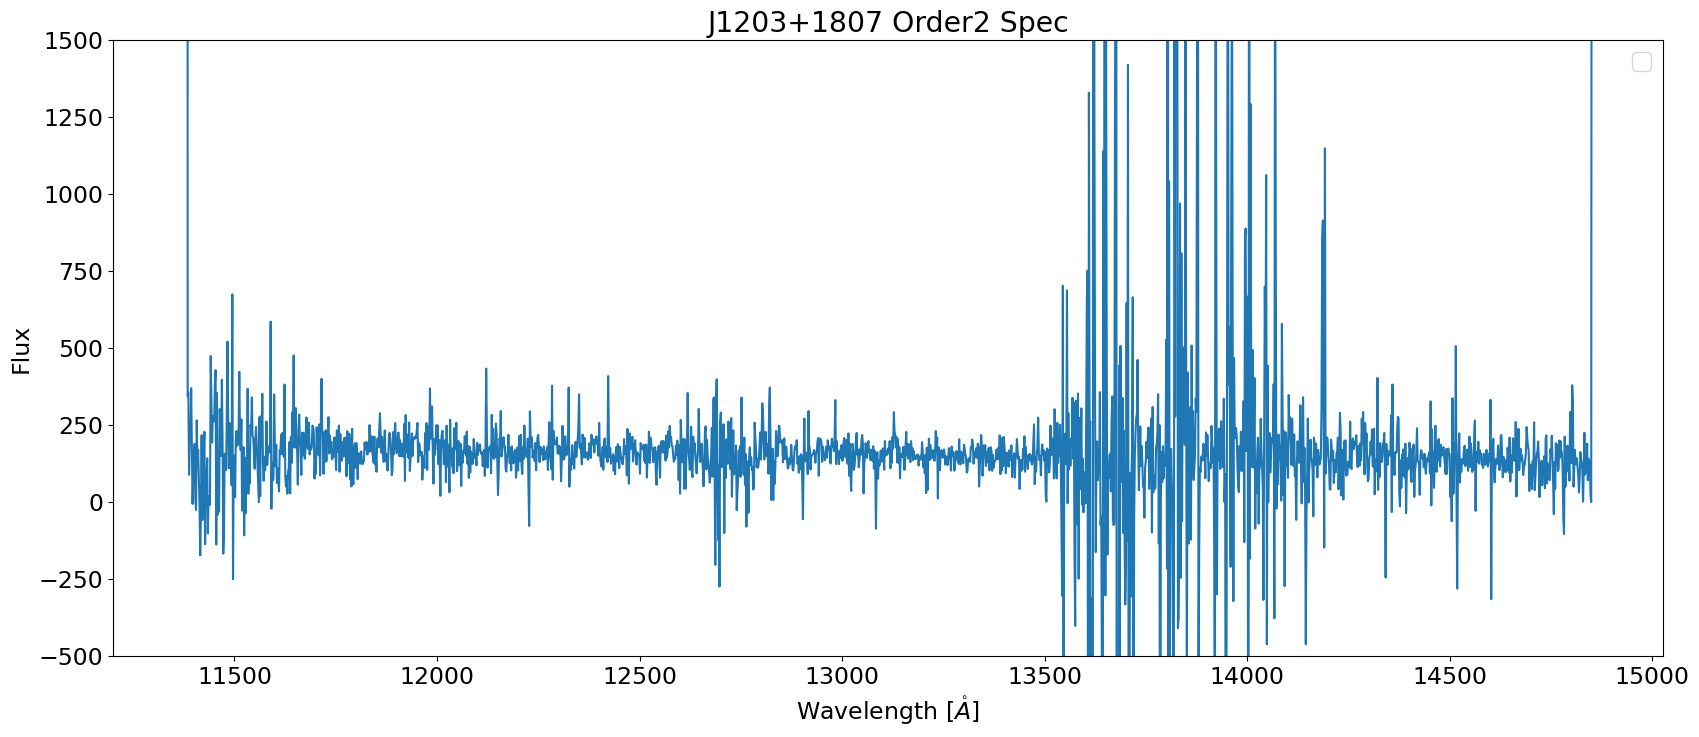

In [11]:
plt.figure(figsize=(20,8))

font = {'size'   : 17}

matplotlib.rc('font', **font)

#plt.plot(sci_wave,tell_flux,c='pink',alpha=0.9,label='telluric')
#plt.plot(sci_wave,sci_flux,c='grey',alpha=0.8,label='uncorrected data')
#plt.plot(sci_wave,tellcorr_sci,c='black',label='corrected data')
#plt.plot(sci_wave,A0_flux_sliced,label='A0V model',alpha=0.7)
#plt.plot(sci_wave,np.sqrt(div0(1,tellcorr_sci_ivar)),c='purple',label='noise')
plt.plot(test_wave,test_flux)

plt.title(f'J1203+1807 Order{order} Spec')
plt.xlabel(r'Wavelength [$\mathring{A}$]')
plt.ylabel('Flux')
#plt.xlim(9400,10800)
plt.ylim(-500,1500)
plt.legend()